In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from collections import defaultdict
import seaborn as sns

base_path = "/export/fs06/psingh54/ActiveRubric-Internal/outputs/results_enhanced_hanna/"

methods = {
    "Gradient VOI: Type Aware Smoothing": "RUN1/enhanced_gradient_voi_q0_human_with_embedding_smoothed.json",
    "Gradient VOI: Basic": "RUN1/enhanced_gradient_voi_q0_human_with_embedding.json",
    "Gradient VOI: Type Aware Smoothing + Variable Level Temperature": "enhanced_gradient_voi_q0_human_with_embedding.json",
    # "Gradient VOI All Questions": "enhanced_gradient_voi_all_questions_with_embedding.json",
    # "Variable Gradient": "enhanced_variable_gradient_comparison_with_embedding.json"
}

def load_results():
    results = {}
    for method_name, filename in methods.items():
        try:
            with open(base_path + filename, 'r') as f:
                results[method_name] = json.load(f)
                print(f"Loaded {method_name}: {len(results[method_name]['test_expected_losses'])} cycles")
        except FileNotFoundError:
            print(f"File not found: {filename}")
    return results

def parse_variable_id(variable_id):
    parts = variable_id.split('_')
    example_idx = int(parts[1])
    position_idx = int(parts[3])
    return example_idx, position_idx

def get_question_selection_distribution(results, dataset_path="/export/fs06/psingh54/ActiveRubric-Internal/outputs/data/active_pool.json"):
    try:
        with open(dataset_path, 'r') as f:
            dataset = json.load(f)
    except:
        print(f"Could not load dataset from {dataset_path}")
        return {}
    
    distributions = {}
    
    for method_name, method_results in results.items():
        question_counts = defaultdict(lambda: {'human': 0, 'llm': 0})
        
        observation_history = method_results.get('observation_history', [])
        
        for obs in observation_history:
            variable_id = obs['variable_id']
            example_idx, position_idx = parse_variable_id(variable_id)
            
            if example_idx < len(dataset):
                entry = dataset[example_idx]
                if position_idx < len(entry['questions']):
                    question_id = entry['questions'][position_idx]
                    annotator_id = entry['annotators'][position_idx]
                    
                    if annotator_id >= 0:
                        question_counts[question_id]['human'] += 1
                    else:
                        question_counts[question_id]['llm'] += 1
        
        distributions[method_name] = question_counts
    
    return distributions

def plot_test_losses(results):
    plt.figure(figsize=(16, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, (method_name, method_results) in enumerate(results.items()):
        cycles = range(len(method_results['test_expected_losses']))
        
        # plt.plot(cycles, method_results['test_expected_losses'], 
        #         color=colors[i], linewidth=2.5, marker='o', markersize=6,
        #         label=f'{method_name} (Expected)', linestyle='-')
        
        plt.plot(cycles, method_results['test_annotated_losses'],
                color=colors[i], linewidth=1.5, marker='s', markersize=6, 
                label=f'{method_name} (Annotated)', linestyle='-', alpha=0.8)
    
    plt.xlabel('Cycle', fontsize=12)
    plt.ylabel('Test Loss', fontsize=12)
    plt.title('Test Loss Comparison', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_validation_metrics(results):
    metrics_to_plot = ['rmse', 'pearson', 'spearman']
    metric_labels = ['RMSE', 'Pearson Correlation', 'Spearman Correlation']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for metric_idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
        ax = axes[metric_idx]
        
        for i, (method_name, method_results) in enumerate(results.items()):
            val_metrics = method_results.get('val_metrics', [])
            cycles = range(len(val_metrics))
            
            metric_values = [m.get(metric, 0) for m in val_metrics]
            
            ax.plot(cycles, metric_values, color=colors[i], linewidth=2.5, 
                   marker='o', markersize=5, label=method_name)
        
        ax.set_xlabel('Cycle', fontsize=10)
        ax.set_ylabel(label, fontsize=10)
        ax.set_title(f'{label} Over Cycles', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if metric_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def plot_question_distribution(distributions):
    if not distributions:
        print("No question distribution data available")
        return
    
    n_methods = len(distributions)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    questions = list(range(7))  # Q0 to Q6
    
    for idx, (method_name, question_counts) in enumerate(distributions.items()):
        ax = axes[idx]
        
        human_counts = [question_counts[q]['human'] for q in questions]
        llm_counts = [question_counts[q]['llm'] for q in questions]
        
        x = np.arange(len(questions))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, human_counts, width, label='Human', 
                      color='#1f77b4', alpha=0.8)
        bars2 = ax.bar(x + width/2, llm_counts, width, label='LLM', 
                      color='#ff7f0e', alpha=0.8)
        
        ax.set_xlabel('Question ID')
        ax.set_ylabel('Selection Count')
        ax.set_title(f'{method_name}\nQuestion Selection Distribution')
        ax.set_xticks(x)
        ax.set_xticklabels([f'Q{i}' for i in questions])
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_question_distribution_summary(distributions):
    if not distributions:
        return
    
    questions = list(range(7))
    methods = list(distributions.keys())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    human_data = []
    llm_data = []
    
    for method in methods:
        human_row = [distributions[method][q]['human'] for q in questions]
        llm_row = [distributions[method][q]['llm'] for q in questions]
        human_data.append(human_row)
        llm_data.append(llm_row)
    
    human_data = np.array(human_data)
    llm_data = np.array(llm_data)
    
    im1 = ax1.imshow(human_data, cmap='Blues', aspect='auto')
    ax1.set_title('Human Annotation Selections', fontweight='bold')
    ax1.set_xlabel('Question ID')
    ax1.set_ylabel('Method')
    ax1.set_xticks(questions)
    ax1.set_xticklabels([f'Q{i}' for i in questions])
    ax1.set_yticks(range(len(methods)))
    ax1.set_yticklabels([m.replace(' ', '\n') for m in methods], fontsize=10)
    
    for i in range(len(methods)):
        for j in range(len(questions)):
            text = ax1.text(j, i, int(human_data[i, j]), ha="center", va="center", 
                          color="white" if human_data[i, j] > human_data.max()/2 else "black")
    
    im2 = ax2.imshow(llm_data, cmap='Oranges', aspect='auto')
    ax2.set_title('LLM Annotation Selections', fontweight='bold')
    ax2.set_xlabel('Question ID')
    ax2.set_ylabel('Method')
    ax2.set_xticks(questions)
    ax2.set_xticklabels([f'Q{i}' for i in questions])
    ax2.set_yticks(range(len(methods)))
    ax2.set_yticklabels([m.replace(' ', '\n') for m in methods], fontsize=10)
    
    for i in range(len(methods)):
        for j in range(len(questions)):
            text = ax2.text(j, i, int(llm_data[i, j]), ha="center", va="center", 
                          color="white" if llm_data[i, j] > llm_data.max()/2 else "black")
    
    plt.tight_layout()
    plt.show()

In [24]:
results = load_results()

Loaded Gradient VOI: Type Aware Smoothing: 17 cycles
Loaded Gradient VOI: Basic: 18 cycles
Loaded Gradient VOI: Type Aware Smoothing + Variable Level Temperature: 18 cycles


Creating Test Loss Plot...


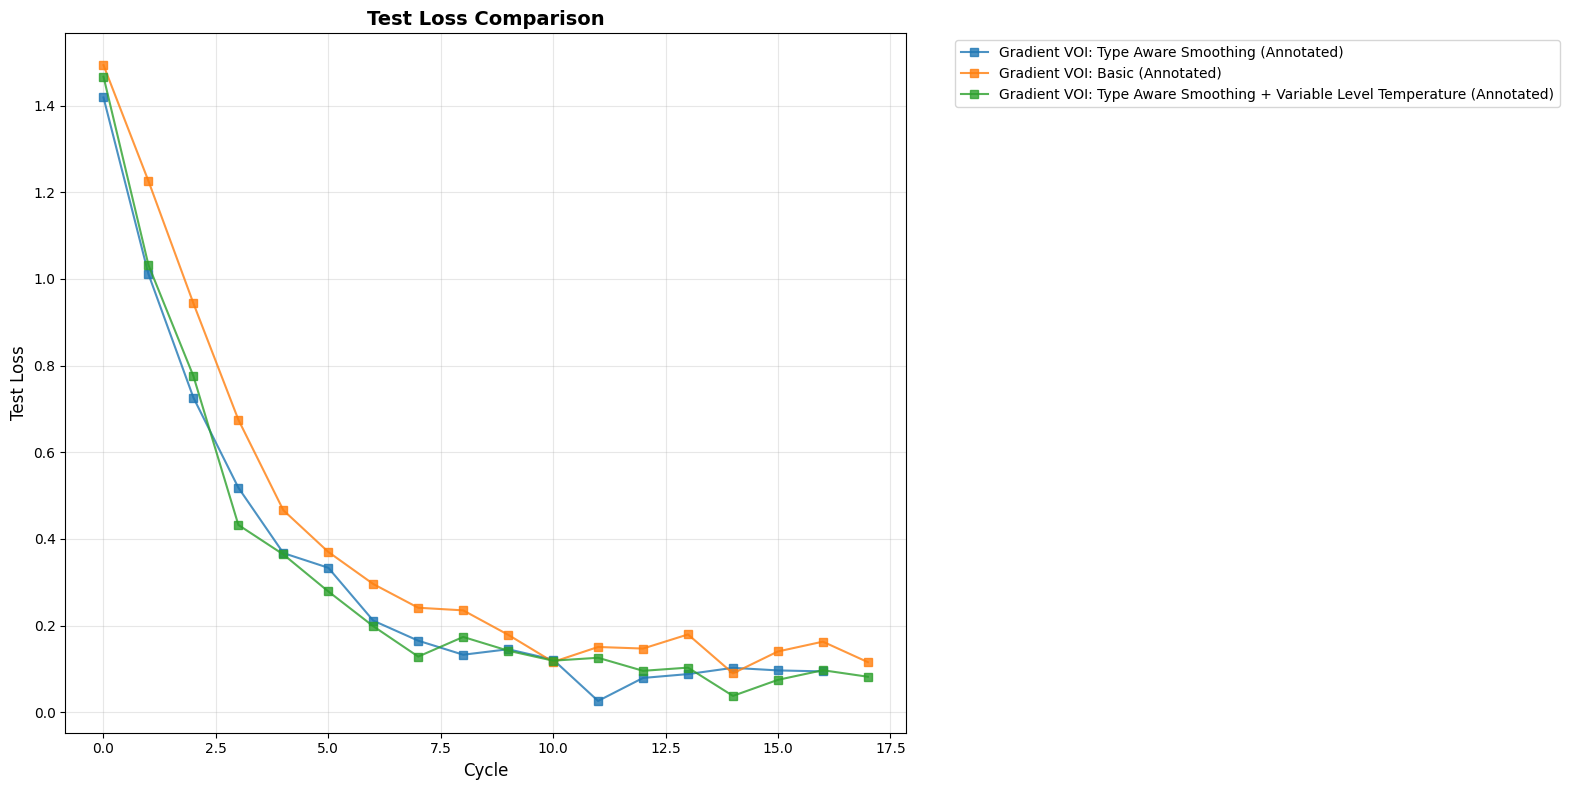

Creating Validation Metrics Plot...


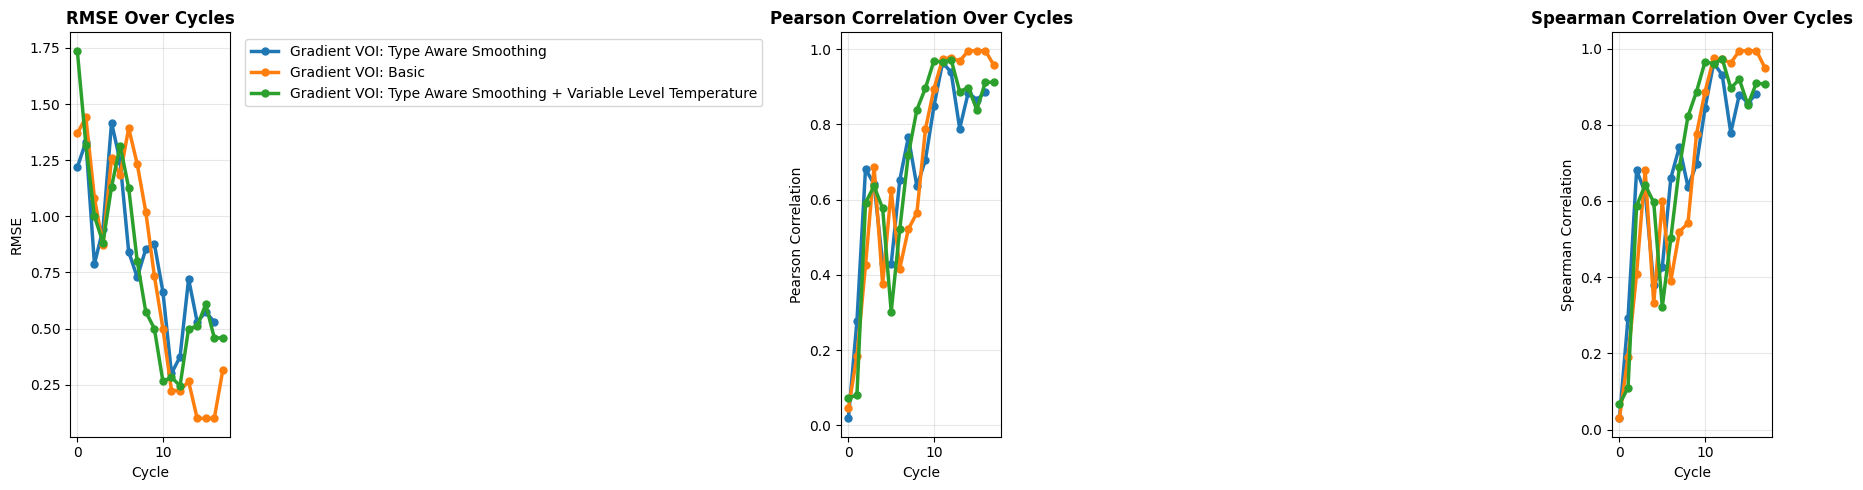

Creating Question Distribution Plots...


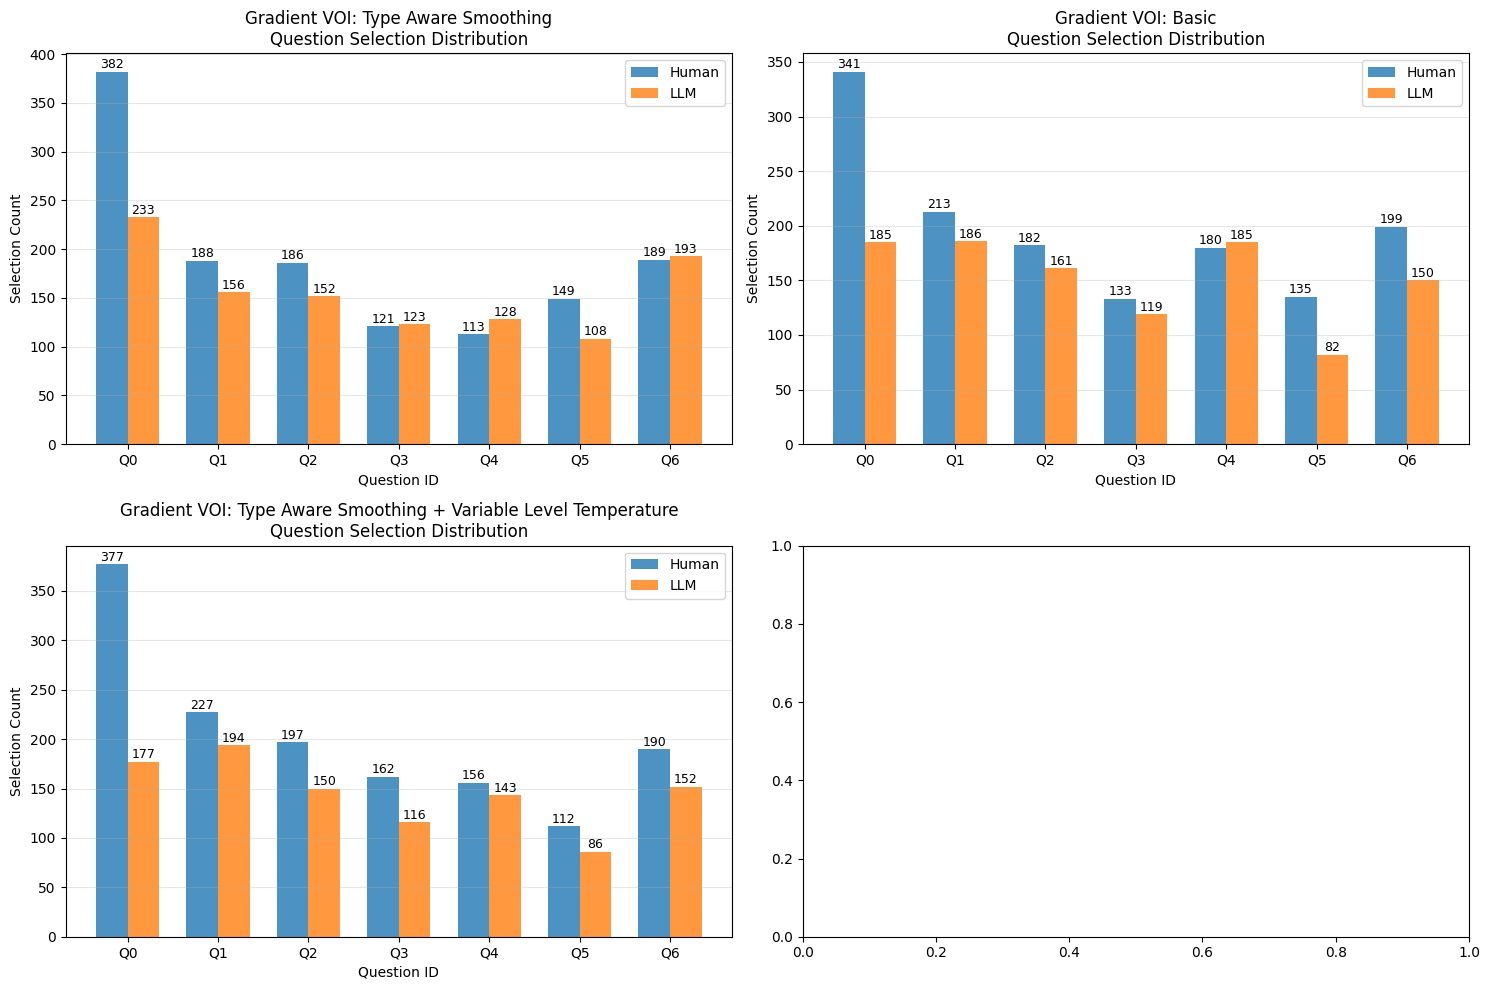

Summary Statistics:
Gradient VOI: Type Aware Smoothing:
  Final test loss: 0.3371
  Total annotations: 2421
  Total question selections: 2421

Gradient VOI: Basic:
  Final test loss: 0.2548
  Total annotations: 2451
  Total question selections: 2451

Gradient VOI: Type Aware Smoothing + Variable Level Temperature:
  Final test loss: 0.3893
  Total annotations: 2439
  Total question selections: 2439



In [25]:
if results:
    print("Creating Test Loss Plot...")
    plot_test_losses(results)
    
    print("Creating Validation Metrics Plot...")
    plot_validation_metrics(results)
    
    print("Creating Question Distribution Plots...")
    distributions = get_question_selection_distribution(results)
    plot_question_distribution(distributions)
    
    print("Summary Statistics:")
    for method_name, method_results in results.items():
        final_test_loss = method_results['test_expected_losses'][-1]
        total_annotations = sum(method_results['features_annotated'])
        print(f"{method_name}:")
        print(f"  Final test loss: {final_test_loss:.4f}")
        print(f"  Total annotations: {total_annotations}")
        if distributions and method_name in distributions:
            total_selections = sum(distributions[method_name][q]['human'] + distributions[method_name][q]['llm'] 
                                 for q in range(7))
            print(f"  Total question selections: {total_selections}")
        print()
else:
    print("No results loaded. Check file paths and run experiments first.")


=== Gradient VOI: Type Aware Smoothing ===
Unique examples annotated: 390
Total annotations: 2421
Average annotations per example: 6.21
Max annotations on single example: 14
Min annotations on single example: 5
Distribution of annotations per example:
  5 annotations: 323 examples (82.8%)
  10 annotations: 33 examples (8.5%)
  14 annotations: 34 examples (8.7%)

=== Gradient VOI: Basic ===
Unique examples annotated: 382
Total annotations: 2451
Average annotations per example: 6.42
Max annotations on single example: 14
Min annotations on single example: 5
Distribution of annotations per example:
  5 annotations: 309 examples (80.9%)
  10 annotations: 29 examples (7.6%)
  14 annotations: 44 examples (11.5%)

=== Gradient VOI: Type Aware Smoothing + Variable Level Temperature ===
Unique examples annotated: 390
Total annotations: 2439
Average annotations per example: 6.25
Max annotations on single example: 14
Min annotations on single example: 5
Distribution of annotations per example:
  

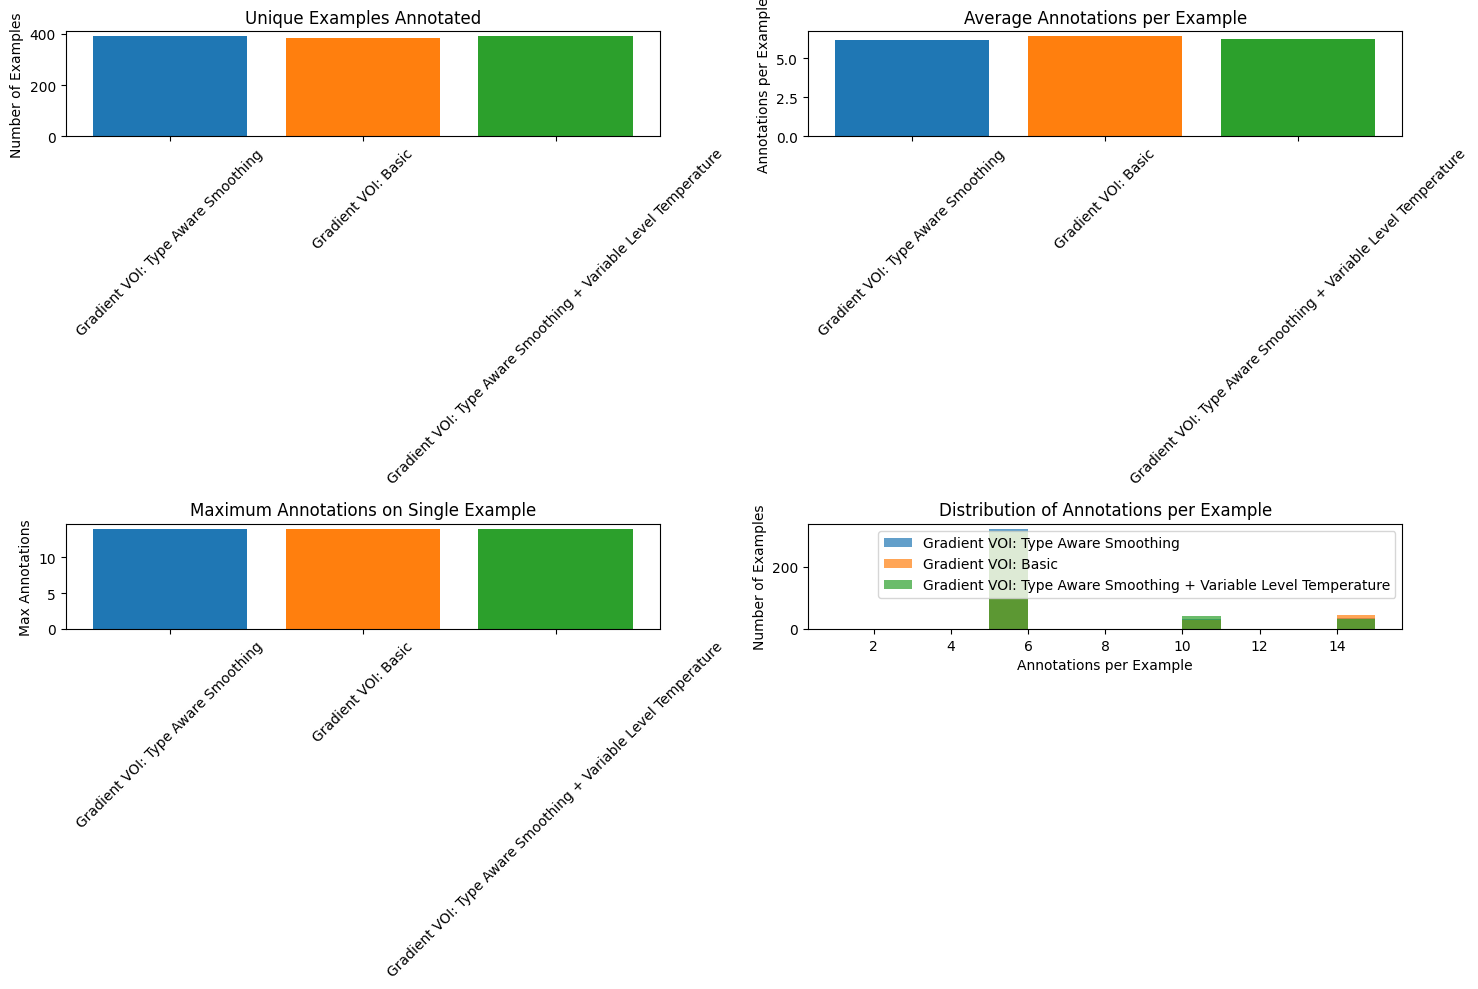

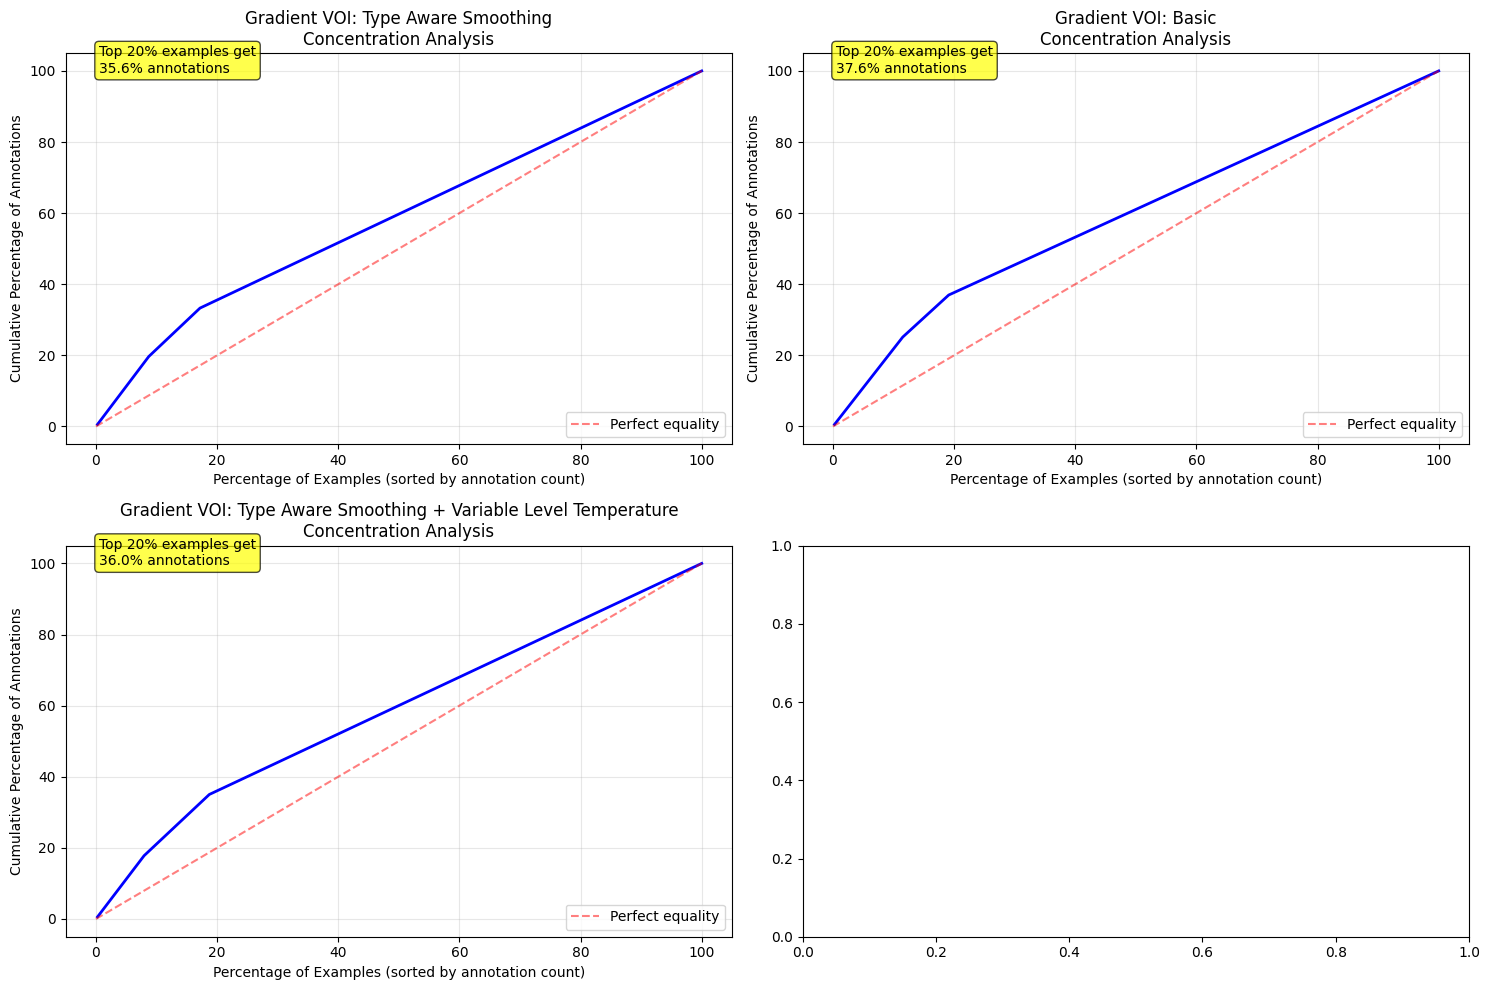

In [22]:
def parse_variable_id(variable_id):
    parts = variable_id.split('_')
    example_idx = int(parts[1])
    position_idx = int(parts[3])
    return example_idx, position_idx

def analyze_example_diversity(results):
    diversity_stats = {}
    
    for method_name, method_results in results.items():
        print(f"\n=== {method_name} ===")
        
        observation_history = method_results.get('observation_history', [])
        
        example_annotation_counts = defaultdict(int)
        
        for obs in observation_history:
            variable_id = obs['variable_id']
            example_idx, position_idx = parse_variable_id(variable_id)
            example_annotation_counts[example_idx] += 1
        
        unique_examples = len(example_annotation_counts)
        total_annotations = sum(example_annotation_counts.values())
        
        annotation_distribution = Counter(example_annotation_counts.values())
        
        print(f"Unique examples annotated: {unique_examples}")
        print(f"Total annotations: {total_annotations}")
        print(f"Average annotations per example: {total_annotations/unique_examples:.2f}")
        print(f"Max annotations on single example: {max(example_annotation_counts.values())}")
        print(f"Min annotations on single example: {min(example_annotation_counts.values())}")
        
        print(f"Distribution of annotations per example:")
        for num_annotations, count_examples in sorted(annotation_distribution.items()):
            percentage = count_examples / unique_examples * 100
            print(f"  {num_annotations} annotations: {count_examples} examples ({percentage:.1f}%)")
        
        diversity_stats[method_name] = {
            'unique_examples': unique_examples,
            'total_annotations': total_annotations,
            'avg_per_example': total_annotations/unique_examples,
            'max_per_example': max(example_annotation_counts.values()),
            'min_per_example': min(example_annotation_counts.values()),
            'annotation_counts': dict(example_annotation_counts),
            'distribution': dict(annotation_distribution)
        }
    
    return diversity_stats

def plot_diversity_comparison(diversity_stats):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    methods = list(diversity_stats.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    unique_examples = [diversity_stats[m]['unique_examples'] for m in methods]
    avg_per_example = [diversity_stats[m]['avg_per_example'] for m in methods]
    max_per_example = [diversity_stats[m]['max_per_example'] for m in methods]
    
    ax1.bar(methods, unique_examples, color=colors)
    ax1.set_title('Unique Examples Annotated')
    ax1.set_ylabel('Number of Examples')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(methods, avg_per_example, color=colors)
    ax2.set_title('Average Annotations per Example')
    ax2.set_ylabel('Annotations per Example')
    ax2.tick_params(axis='x', rotation=45)
    
    ax3.bar(methods, max_per_example, color=colors)
    ax3.set_title('Maximum Annotations on Single Example')
    ax3.set_ylabel('Max Annotations')
    ax3.tick_params(axis='x', rotation=45)
    
    for i, method in enumerate(methods):
        annotation_counts = list(diversity_stats[method]['annotation_counts'].values())
        ax4.hist(annotation_counts, bins=range(1, max(annotation_counts)+2), 
                alpha=0.7, label=method, color=colors[i])
    
    ax4.set_title('Distribution of Annotations per Example')
    ax4.set_xlabel('Annotations per Example')
    ax4.set_ylabel('Number of Examples')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

def plot_concentration_analysis(diversity_stats):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (method_name, stats) in enumerate(diversity_stats.items()):
        ax = axes[idx]
        
        annotation_counts = list(stats['annotation_counts'].values())
        sorted_counts = sorted(annotation_counts, reverse=True)
        
        cumulative_annotations = np.cumsum(sorted_counts)
        total_annotations = sum(annotation_counts)
        cumulative_percentage = cumulative_annotations / total_annotations * 100
        
        examples_percentage = np.arange(1, len(sorted_counts)+1) / len(sorted_counts) * 100
        
        ax.plot(examples_percentage, cumulative_percentage, linewidth=2, color='blue')
        ax.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='Perfect equality')
        
        ax.set_xlabel('Percentage of Examples (sorted by annotation count)')
        ax.set_ylabel('Cumulative Percentage of Annotations')
        ax.set_title(f'{method_name}\nConcentration Analysis')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        top_20_pct_examples = int(0.2 * len(sorted_counts))
        top_20_pct_annotations = cumulative_annotations[top_20_pct_examples-1] / total_annotations * 100
        ax.text(0.05, 0.95, f'Top 20% examples get\n{top_20_pct_annotations:.1f}% annotations', 
                transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

results = {}
for method_name, filename in methods.items():
    try:
        with open(base_path + filename, 'r') as f:
            results[method_name] = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {filename}")

if results:
    diversity_stats = analyze_example_diversity(results)
    plot_diversity_comparison(diversity_stats)
    plot_concentration_analysis(diversity_stats)
else:
    print("No results loaded")